<a id='top'></a>

# CSCI 3202, Spring 2018
# Assignment 4
# Due:  Friday 23 March 2018 by 12:00 PM

<br>

### Your name:

<br>

**Note:** Some packages to load, helper functions and unit tests are defined at [the bottom of this notebook](#helpers)

Shortcuts:  [top](#top) || [1](#p1) | [1a](#p1a) | [1b](#p1b) | [1c](#p1c) | [1d](#p1d) | [1e](#p1e) | [1f](#p1f) | [1g](#p1g) | [1h](#p1h) || [2](#p2) | [2a](#p2a) | [2b](#p2b) | [2c](#p2c) | [2d](#p2d) | [2e](#p2e) || [3](#p3) | [3a](#p3a) | [3b](#p3b) | [3c](#p3c) | [3d](#p3d) | [3e](#p3e) || [helpers](#helpers)

**Before you begin:** You will also need to download a few data sets from the Piazza page, under the Resources tab.
1. data_sealevel.csv
1. data_temperature.csv
1. data_socks.csv

---

<a id='p1'></a>[Back to top](#top)

## Problem 1:  Calibrating a model for global mean sea level changes

<img src="http://www.anthropocenemagazine.org/wp-content/uploads/2017/05/future-sea-levels.jpg" width="250">

<a id='p1a'></a>

### (1a) Load and plot some data.

Let's load a couple data sets.  One is a data set of global mean sea levels, and the other is a data set of global mean temperatures:
* `sealevel` will be a list of global mean sea levels (millimeters)
* `sealevel_sigma` will be a list of the *uncertainty* in global mean sea levels (millimeters), and
* `temperature` will be a list of global mean temperatures (degrees Celsius).

Note that depending on where you save these CSV data files, you may need to change the file names below in the `pd.read_csv` function calls to reflect the proper paths.

In [219]:
year = []
sealevel = []
sealevel_sigma = []
temperature = []

dfSealevel = pd.read_csv("data_sealevel.csv")
dfTemperature = pd.read_csv("data_temperature.csv")

# We aren't doing any heavy-duty stats stuff, so let's just keep what we need as regular lists
year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()
sealevel_sigma = dfSealevel["uncertainty"].tolist()
temperature = dfTemperature["temperature"].tolist()

**Check** to make sure (1) temperature, year and sea level time series are all the same length and period; (2) data need to be properly *normalized* against some reference period. In climate science, often the years 1961-1990 are used as the reference period.  So conduct a check to make sure that the mean sea level and mean global mean temperature for the 1961-1990 (inclusive) period are both 0.

In [220]:
#Check length
print(len(temperature) == len(year) == len(sealevel))

dfSealevel_qualified = dfSealevel[(dfSealevel["year"] >= 1961) & (dfSealevel["year"] <= 1990)]
dfTemperature_qualified = dfTemperature[(dfTemperature["year"] >= 1961) & (dfTemperature["year"] <= 1990)]
print("Sealevel mean: ", round(dfSealevel_qualified["sealevel"].mean()))
print("Temperature mean: ", round(dfTemperature_qualified["temperature"].mean()))
                                  
print(len(temperature) == len(year))



True
Sealevel mean:  0
Temperature mean:  0
True


Plot the data points as a scatter plots, and plot them side-by-side-by-side (one row, three columns of figures). The point here is learn how to customize your figures a bit more, and also because computer screens are (typically) wider than they are tall.

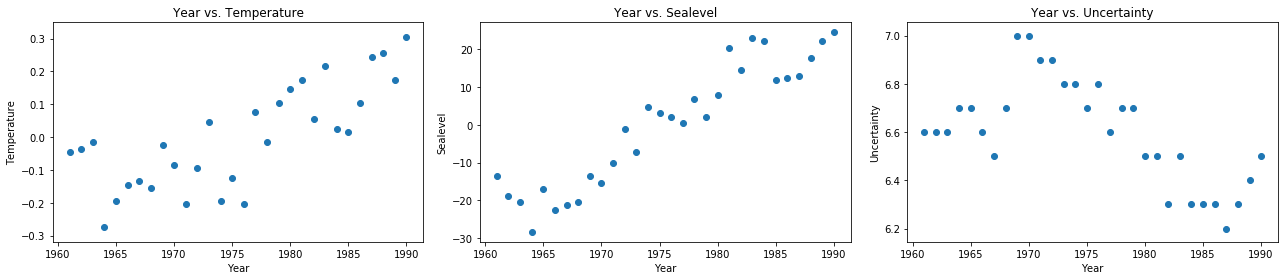

In [221]:
plt.subplots(1, 3, figsize = (18,4))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

plt1 = plt.subplot(1,3,1)

plt.title("Year vs. Temperature")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature")
plt.scatter(dfTemperature_qualified['year'], dfTemperature_qualified['temperature'])

plt.subplot(1,3,2)
plt.title("Year vs. Sealevel")
ax2.set_xlabel("Year")
ax2.set_ylabel("Sealevel")
plt.scatter(dfSealevel_qualified['year'], dfSealevel_qualified['sealevel'])

plt.subplot(1,3,3)
plt.title("Year vs. Uncertainty")
ax3.set_xlabel("Year")
ax3.set_ylabel("Uncertainty")
plt.scatter(dfSealevel_qualified['year'], dfSealevel_qualified['uncertainty'])

plt.tight_layout()
plt.show()

**Question:** How does the uncertainty in global mean sea levels change as a function of time?  When is the uncertainty the highest?  Give one reason why you think this might be the case.

**Your answer:**

The methods of taking measurements has probably improved over time, and they've taken more readings over time, so it's easier to ascertain the accuracy of a measurement as there is a wide base of measurements to make comparisons against. As expected, observing the graph, there is a general downward curve towards a lower level uncertainty.

Likewise, it is possible that larger changes in overall global norms lead to some uncertainty in our answers and measurements during the associated time frame (around 1970) wherein the data was most askew.

<br>

<a id='p1b'></a>

### (1b)  The "out-of-box" sea-level model

In your plot from **(1a)**, you should see quite an apparent relationship between increasing temperatures and rising sea levels.  Seeems like someone should try to model the relationship between those two, huh?

In the [helper functions below](#helpers), a simple model for temperature-driven changes in global mean sea level (GMSL) is defined. This is the model of [Rahmstorf (2007)](http://science.sciencemag.org/content/315/5810/368).

The `slr` model takes two parameters, $\alpha$ and $T_{eq}$, and requires a time series of global mean temperatures: `slr(alpha, Teq, temperature)`.
* `alpha` is the sensitivity of sea-level changes to changes in global temperature. The units for $\alpha$ are millimeters of sea-level changes per year, or mm y$^{-1}$.
* `Teq` is the equilibrium global mean temperature, with units of degrees Celsius.
* `temperature` is the time series of global mean surface temperatures, assumed to be relative to the 1961-1990 mean. We read a temperature data set above, which we will use for this input.

For now, you do not need to worry too much about how this model works.  It is very simple, and widely used, but the point here is that you can plug in a particular set of temperatures (the model **forcing**) and parameters ($\alpha$ and $T_{eq}$), and out pops a time series of simulated global mean sea levels.

**Our goal:**  pick good values for $\alpha$ and $T_{eq}$, so that when we run the `slr` model using the observations of temperature (which we plotted above), the model output matches well the observations of global mean sea level (which we also plotted above).

The whole process of figuring out what these good parameter values are is called **model calibration**, and it's awesome.  Let's have a look at why we need to do any calibration in the first place, shall we?

The default parameter choices given in the Rahmstorf (2007) paper are $\alpha=3.4$ mm y$^{-1}$ and $T_{eq} = -0.5\ ^{\circ}$C.

Make a plot that contains:
* the observed sea level data as scatter points
* the modeled sea levels as a line, using the temperature observations from above as the `temperature` input
* an appropriate legend and axis labels
* $x$ axis is years
* $y$ axis is sea level

Note that after you run the `slr` model, you will need to **normalize** the output relative to the 1961-1990 reference period.  That is because you are going to compare it against data that is also normalized against this reference period. The `years` that correspond to the model output should be the same as the `years` that correspond to the `temperature` input.

-3.34059298742e-11


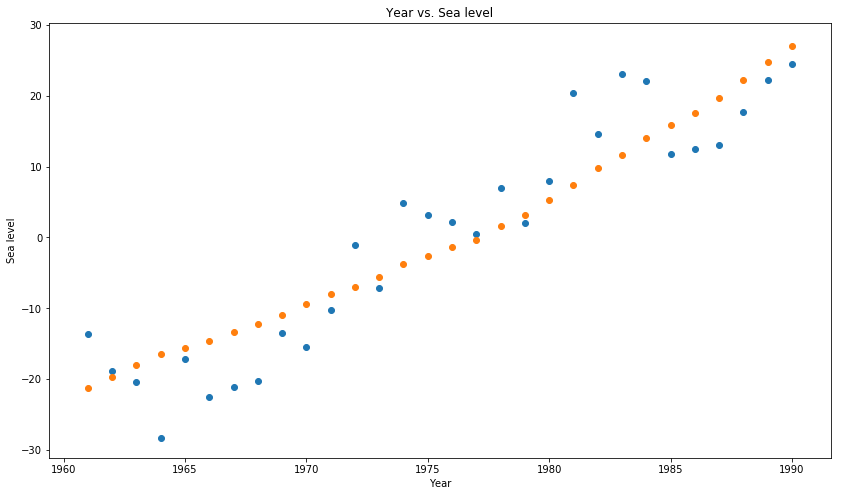

In [229]:
pd.options.mode.chained_assignment = None

adjusted_levels = slr(3.4, -0.5, temperature)
year_norm = []
adjusted_norm = []
sea_level_norm = []

for i in range(len(year)):
    if year[i] <= 1990 and year[i] >= 1961:
        year_norm.append(year[i])
        adjusted_norm.append(adjusted_levels[i])
        sea_level_norm.append(sealevel[i])
for i in range(len(adjusted_norm)):
    adjusted_norm[i] += 49.4698233333
    
plt.subplots(figsize = (14, 8))
plt.title("Year vs. Sea level")
plt.xlabel("Year")
plt.ylabel("Sea level")
plt.scatter(year_norm, sea_level_norm)
plt.scatter(year_norm, adjusted_norm)

adjusted_mean = np.mean(adjusted_levels)


print(np.mean(adjusted_norm))
plt.show()

Your plot above ought to show decent match for the late 1900s, but diverge a bit further back in time.

**The point:**  We can do better than this "out-of-the-box" version of the Rahmstorf sea level model.

The lines roughly overlap and they are as close to zero as I can reach, and thus have been normalized.

<br>

<a/ id='p1c'></a>

### (1c)   Figuring out our objective function

As our **objective function**, we will use the joint likelihood function of the observed sea level data, given the model simulation.  For a single data point $y_i$ in year $i$, with associated uncertainty $\sigma_i$, we can assume the likelihood for our model simulation in year $i$, $\eta_i$, follows a normal distribution centered at the data point ($y_i$) and with standard deviation given by the associated uncertainty ($\sigma_i$).  The model simulation is a **deterministic** result of our parameter choices $\alpha$ and $T_{eq}$, so we write the likelihood as:

$$L(y_i \mid \alpha, T_{eq}) = \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}$$

But that only uses a single data point.  Let's use all the data!  The **joint likelihood** is the product of all of the likelihoods associated with the individual data points.

$$L(\mathbf{y} \mid \alpha, T_{eq}) = \prod_{i=1}^N L(y_i \mid \alpha, T_{eq})$$

However, this joint likelihood is the product of a lot of numbers that are less than 1, so it will be **tiny**.  Instead, we should try to optimize the **joint log-likelihood**, which is simply the (natural) logarithm of the joint likelihood function.

$$l(\mathbf{y} \mid \alpha, T_{eq}) = \log{(L(y \mid \alpha, T_{eq}))}$$

**Show** (using math) that if we assume the observational data ($y_i$) are all independent, then the joint log-likelihood is:

$$l(\mathbf{y} \mid \alpha, T_{eq}) =  -\dfrac{N}{2} \log{(2\pi)} - \sum_{i=1}^N \log{(\sigma_i)} - \dfrac{1}{2}\sum_{i=1}^N \left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$

where, $\mathbf{y} = [y_1, y_2, \ldots, y_N]$ is the entire vector (list) of sea level observations, $\eta(\alpha, T_{eq}) = [\eta_1(\alpha, T_{eq}), \eta_2(\alpha, T_{eq}), \ldots, \eta_N(\alpha, T_{eq})]$ is the entire vector (list) of `slr` model output when the parameter values $\alpha$ and $T_{eq}$ are used, and $N$ is the number of observations we have.

**Note:** Yes, I'm mixing the typical indexing of $1-N$ with what you'll need to implement, which is the Pythonic $0-(N-1)$. Keep this in mind as you code.

# Show using nice LateX/Markdown formatting...

$$L(\mathbf{y} \mid \alpha, T_{eq}) = \prod_{i=1}^N L(y_i \mid \alpha, T_{eq}) = \dfrac{1}{\sqrt{2 \pi} \sigma_1} e^{-\dfrac{(\eta_1(\alpha, T_{eq}) - y_1)^2}{2\sigma_1^2}} * \dfrac{1}{\sqrt{2 \pi} \sigma_2} e^{-\dfrac{(\eta_2(\alpha, T_{eq}) - y_2)^2}{2\sigma_2^2}} * ... \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}  $$


$$l(\mathbf{y} \mid \alpha, T_{eq}) = \log{(L(y \mid \alpha, T_{eq}))}$$

$$ \log{(L(y \mid \alpha, T_{eq}))} = log(\prod_{i=1}^N L(y_i \mid \alpha, T_{eq})) = log(\dfrac{1}{\sqrt{2 \pi} \sigma_1} e^{-\dfrac{(\eta_1(\alpha, T_{eq}) - y_1)^2}{2\sigma_1^2}} * \dfrac{1}{\sqrt{2 \pi} \sigma_2} e^{-\dfrac{(\eta_2(\alpha, T_{eq}) - y_2)^2}{2\sigma_2^2}} * ... \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}) $$


$$l(\mathbf{y} \mid \alpha, T_{eq}) =  -\dfrac{N}{2} \log{(2\pi)} - \log{(\sigma_1)} - \left( \dfrac{\eta_1(\alpha, T_{eq}) - y_1}{\sigma_1} \right)^2 -\dfrac{N}{2} \log{(2\pi)} - \log{(\sigma_2)} - \dfrac{1}{2}\left( \dfrac{\eta_2(\alpha, T_{eq}) - y_2}{\sigma_2} \right)^2 + ... + -\dfrac{N}{2} \log{(2\pi)} - \log{(\sigma_i)} - \dfrac{1}{2}\left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$


$$ l(\mathbf{y} \mid \alpha, T_{eq}) = -\dfrac{N}{2} \log{(2\pi)} - \sum_{i=1}^N \log{(\sigma_i)} - \dfrac{1}{2}\sum_{i=1}^N \left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$

<br>

<a/ id='p1d'></a>

### (1d)   Defining our objective function

Now define a `log_likelihood(parameters, obs_temp, obs_mu, obs_sigma)` function:
* `parameters`: argument that is a list of two parameter values, $[\alpha, T_{eq}]$
  * within the likelihood function, you will need to generate the model simulation $\eta(\alpha, T_{eq})$ using the input `parameters`, for comparison against the observational data
* `obs_temp`: argument that is a time series (list) of observed global mean temperatures, that will be used to run the `slr` model. Provide a default value of `temperature` for this, because we only have one temperature data set to use, and we don't want to keep typing out inputs for this.
* `obs_mu`: argument that is a time series (list) of observed values, that will be used for comparison against the `model` output. Provide a default value of `sealevel` here, again because we won't be changing the observational data.
* `obs_sigma`: argument that is a time series (list) of the corresponding uncertainties in the observational data. Simiarly, provide a default value of `sealevel_sigma` here.
* all three of these `obs_*` inputs should be lists, and should be the same length
* this routine should return a **single** float number, that is the joint log-likelihood of the given `model` simulation.

You may find the `scipy.stats` package to be useful here, or you can calculate this straight from the equation above.

In [230]:
def log_likelihood(parameters, obs_temp=temperature, obs_mu=sealevel, obs_sigma=sealevel_sigma):
    v1, v2, v3 = 0, 0, 0
    
    v1 = len(obs_temp) / 2 * np.log(2*np.pi)
    n_i = slr(parameters[0], parameters[1], obs_temp)
    
    for i in range(0, len(obs_temp)):
        v2 = v2 + np.log(obs_sigma[i])
        v3 = v3 + ((n_i[i] - obs_mu[i])/obs_sigma[i])**2
        
    v3 *= 0.5
    
    joint_log = -1 * (v1 + v2 + v3)
    
    return joint_log

<br>

<a/ id='p1e'></a>

### (1e)  Playing with our shiny new objective function!

Armed with our **log-likelihood** objective function, let's see what it looks like for various values of $\alpha$, while keeping $T_{eq}$ fixed at its default value ($T_{eq}=-0.5$). Try a variety of $\alpha$ values. Use a wide enough range that you can tell what the behavior of the $\alpha$-log-likelihood relationship is from a plot of the two (below).

Then, make a plot of the resulting log-likelihood values, as a function of the values for the $\alpha$ parameter used. Label your axes appropriately.

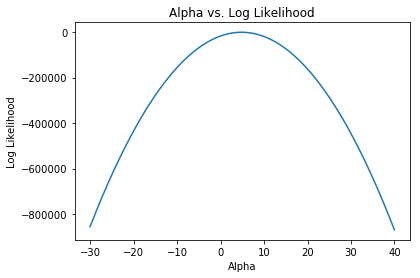

In [233]:
params = [0, -0.5]
y_vals = []
alpha = []

for i in range(-1500, 2000):
    val = i/50
    params[0] = val
    y_vals.append(val)
    alpha.append(log_likelihood(params))

plt.plot(y_vals, alpha)
plt.title("Alpha vs. Log Likelihood")
plt.xlabel("Alpha")
plt.ylabel("Log Likelihood")
plt.show()

Now explore a range of values around the default of $T_{eq}= -0.5 ^{\circ}$C, while keeping the $\alpha$ parameter constant at its default of 3.4 mm y$^{-1}$. Generate a plot of some test values of $T_{eq}$ against the resulting log-likelihood function values.  Label your axes.

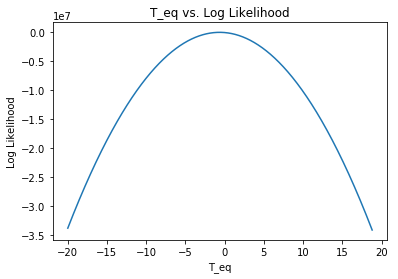

In [238]:
params = [3.4, 0]
y_vals = []
t_eq = []

for i in range(-940, 1000):
    params[1] = (-1 * i/50)
    y_vals.append(-1*i/50)
    t_eq.append(log_likelihood(params))
    
plt.plot(y_vals, t_eq)
plt.title("T_eq vs. Log Likelihood")
plt.xlabel("T_eq")
plt.ylabel("Log Likelihood")
plt.show()

**Reflection 1:** Write a sentence or two commenting on these two plots.  What do you think are the best values for $\alpha$ and $T_{eq}$ (so far)?

Our overall objective, in a perfect world, is to get our Log Likelihood value to be equal to 0, as that would indicate a perfect model of our data. As a result, we are trying to minimize the value of Log Likelihood as we do not have a perfect model.

In this case the best value for $\alpha$ is in the band of 0 to 5, estimated at ~2.5
Whereas, for $T_eq$, the best value would be between -5, and 5, estimated to be at ~ 0

**Reflection 2:** How *likely* do values of $\alpha < 0$  or $T_{eq} > 0$ appear to be?  If these values are implausible, what does that mean in terms of the sea level-temperature system that we are modeling?  You should talk about the actual physical system, not just vague statements like "$\alpha < 0$ looks improbable".  While that statement is true, it is not very insightful.

If we consider the definitions of our variables, wherein $\alpha$ is the sensitivity of sea-level changes to changes in global temperature (in units of mm per year); and $T_{eq}$ is the equilibrium global mean temperature (units of degrees Celsius). 

In the case of $\alpha$, it does not make much sense that our sea-levels would get lower as our temperature went up (to have a negatively correlated relationship), so $\alpha$ < 0 seems highly implausible. Likewise, our data seems to support that a somewhat positive relationship is present (with a best guess value of $\alpha$ estimated at 2.5).

Similarly, in the case of $T_{eq}$, it would seem that our value would be best estimated at a slightly negative value (where our best guess was at 0). This makes sense, as the world has more cold places than it does warm ones. As a result, it seems unlikely that our data would be in a positive region, as that means the global mean would be much higher than it is.

**Reflection 3:** Based on your plots above, do you think one of hill-climbing or simulated annealing will work better than the other to find the global maximum in the objective function, or does it appear that either will find the optimum?

I suspect that Simulated Annealing should give better results (and by better, I mean, more accurate). This is due to the fact that Simulated Annealing, at least in concept, should be much better at dealing with turbulent sets of data. This is mostly due to the fact that the random restarts allow for the Annealer to deal with local optima much better than its hill climbing cousin.

While accurate, the hill-climbing algorithm has a huge shortcoming when there are multiple hills close to one another and is very liable to get stuck.

<br>

<a/ id='p1f'></a>

### (1f)  Defining our class structure

That exploration was a nice way to get a sense of how the $\alpha$ and $T_{eq}$ parameters affect the quality of the model output, but it was not particularly rigorous. Let's apply our **hill-climbing** algorithm to this problem.

Using our in-class activity as a guide, do the following:

* Define a `State` class, with attributes for the parameter values (which define the state) and the objective function value of that state.
* Define a `Problem_hillclimb` **sub-class** of the more general class `Problem`, with:
  * ~~attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$~~.
  * ~~methods for `moves` (return the list of all possible moves from the current state) and `best_move` (return the move that maximizes the objective function)~~.
  * ~~the `moves` available should be in proper 2-dimensional space.  Do **not** simply optimize one parameter, keeping the other fixed, then optimize the other parameter, while keeping the first fixed.  (*That method *can* work, but there are some theoretical issues that would need to be tackled, and we are not getting into that here.*) You are allowed to restrict yourself to movements along a grid, as long as you entertain steps in both the $\alpha$ and the $T_{eq}$ directions~~.
  * The `Problem` class should have everything in it that you might need to apply different optimization algorithms, while the `Problem_hillclimb` sub-class will have the methods and attributes specific to hill-climbing defined.
* Define the `hill_climb` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `hill_climb(problem, n_iter)`:  arguments are a `Problem_hillclimb` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

Subject to the above constraints, you may implement these however you would like. **If you do not use a sub-class (properly), you will lose points.** 

In [242]:
class State:
    def __init__(self, value, obj_value):
        self.value = value
        self.obj_value = obj_value
        self.log_list = []
        self.alpha_list = []
        self.teq_list = []

In [243]:
class problem:
    def __init__(self, initial_state, objective_function, stepsize):
        self.current_state = initial_state
        self.objective_function = objective_function
        self.stepsize = stepsize
        
    def moves(self):
        # depend on self.current_state
        poss_moves = []
        #increase alpha, increase T_eq
        poss_moves.append((self.current_state.value[0] + self.stepsize, self.current_state.value[1] + self.stepsize))
        #increase alpha, decrease T_eq
        poss_moves.append((self.current_state.value[0] + self.stepsize, self.current_state.value[1] - self.stepsize))
        #decrease alpha, decrease T_eq
        poss_moves.append((self.current_state.value[0] - self.stepsize, self.current_state.value[1] - self.stepsize))
        #decrease alpha, increase T_eq
        poss_moves.append((self.current_state.value[0] - self.stepsize, self.current_state.value[1] + self.stepsize))
        #decrease alpha
        poss_moves.append((self.current_state.value[0] - self.stepsize, self.current_state.value[1]))
        #decrease T_eq
        poss_moves.append((self.current_state.value[0], self.current_state.value[1] - self.stepsize))
        #increase alpha
        poss_moves.append((self.current_state.value[0] + self.stepsize, self.current_state.value[1]))
        #increase T_eq
        poss_moves.append((self.current_state.value[0], self.current_state.value[1] + self.stepsize))
                
        return(poss_moves)

In [244]:
class Problem_hillclimb(problem):
    
    def best_move(self):
        poss_moves = self.moves()
        # calc objective function value for each possible move
        obj_func = [self.objective_function(move) for move in poss_moves]
        # pick the best move
        best = poss_moves[max(zip(obj_func, range(len(obj_func))))[1]]
        return best
    
def hill_climb(problem, n_iter):
    for t in range(n_iter):
        problem.current_state.value = problem.best_move()
        problem.current_state.obj_value = problem.objective_function(problem.current_state.value)
    return problem
    
initial_state = State(value = (3.4, -0.5), obj_value = log_likelihood((3.4, 0.5))) 

log_problem = Problem_hillclimb(initial_state = initial_state, objective_function= log_likelihood, stepsize=0.001)

out = hill_climb(log_problem, n_iter=5000)
print(out.current_state.value, out.current_state.obj_value)
vals = out.current_state.value

alpha = vals[0]
teq = vals[1]


(1.9800000000001563, -0.9440000000000004) -465.227340339


**Now:**
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a hill-climbing problem object, using this initial state, the joint log-likelihood objective function, and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
3. ***hill-climb!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line (using a different color!)
  * include axis labels and a legend
  
**"Unit tests":**
* As a benchmark, make sure that your log-likelihood is *at least* -500.
* Your calibrated (optimized) model simulation should be going pretty much straight through the data points.
* Remember to normalize your model against the 1961-1990 reference period.

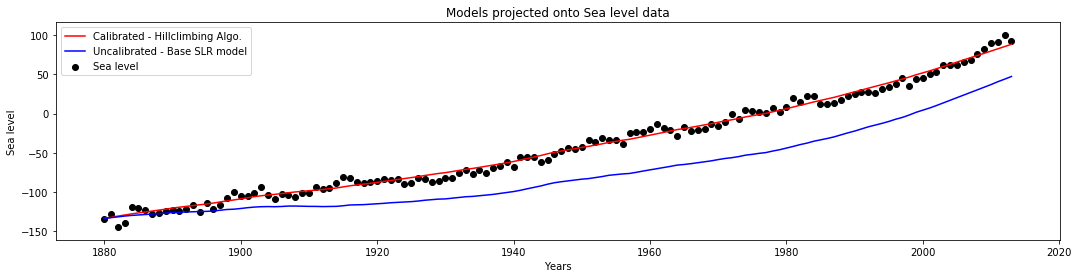

In [245]:
plt.subplots(1, 1, figsize = (18,4))
calibrated = slr(alpha, teq, temperature)
uncalibrated = slr(3.4, -0.5, temperature)
plt.title("Models projected onto Sea level data")
plt.xlabel("Years")
plt.ylabel("Sea level")
plt.plot(year, calibrated, c = "red", label = "Calibrated - Hillclimbing Algo.")
plt.scatter(year, sealevel, c = "black", label = "Sea level")
plt.plot(year, uncalibrated, c = "blue", label = "Uncalibrated - Base SLR model")
plt.legend()
plt.show()

In [246]:
print(out.current_state.obj_value > -500 and out.current_state.obj_value < 0)
print(out.current_state.obj_value)

True
-465.227340339


<br>

<a/ id='p1g'></a>

### (1g)  Simulated annealing

Let's re-calibrate the `slr` model. This time, we will use **simulated annealing**. Again, using our in-class activity as a guide, do the following:

* Continue to use your `State` class above.
* Define a `Problem_annealing` sub-class of the `Problem` class, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * a method for `random_move`, to pick a random move **by drawing from a multivariate normal distribution**.  You should use the `stepsize` attribute as the covariance (width) for this.
* Define the `simulated_annealing` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `simulated_annealing(problem, n_iter)`:  arguments are a `Problem_annealing` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum, and corresponding objective function value

Subject to the above constraints, you may implement these however you would like.

In [251]:
class problem:
    def __init__(self, initial_state, objective_function, stepsize):
        self.current_state = initial_state
        self.objective_function = objective_function
        self.stepsize = stepsize
        
class Problem_annealing(problem):
    def random_move(self):
        x = [[self.stepsize, 0], [0, self.stepsize]]
        x = np.diag(np.diag(x))
        return np.random.multivariate_normal((self.current_state.value[0], self.current_state.value[1]), x)

def simulated_annealing(problem, n_iter):
    for t in range(n_iter): 
        temp_scheduler = 5 / (t + 1) ** 0.5

        move = problem.random_move()

        delta_e = problem.objective_function(move) - problem.current_state.obj_value

        probability = np.exp(delta_e/temp_scheduler)

        if delta_e > 0 or np.random.choice((1,0), p = (probability, 1-probability)):
            problem.current_state.value = move
            problem.current_state.obj_value = problem.objective_function(move)

    return problem.current_state


**Now:**
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a simulated annealing problem object, using this initial state, the log-likelihood objective function, an appropriate temperature updating schedule and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
  * note that this "temperature" is distinct from the actual physical temperature used as input to drive the `slr` model
3. ***anneal!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line (using a different color!)
  * include axis labels and a legend
  
**"Unit tests":**  How does your model look when you plot it against the data? If it doesn't look good, then you failed this unit test :(

In [252]:
initial_state = State(value = (3.4, -0.5), obj_value = log_likelihood((3.4, -0.5))) 

anull = Problem_annealing(initial_state, log_likelihood,0.001)

out = simulated_annealing(anull, n_iter = 10000)
print(out.value, out.obj_value)

[ 1.93875664 -0.96120674] -465.235421052


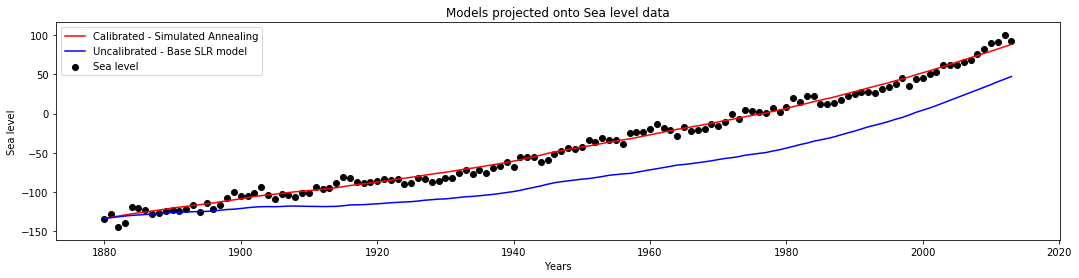

In [253]:
alpha = out.value[0]
teq = out.value[1]
plt.subplots(1, 1, figsize = (18,4))
calibrated = slr(alpha, teq, temperature)
uncalibrated = slr(3.4, -0.5, temperature)
plt.title("Models projected onto Sea level data")
plt.xlabel("Years")
plt.ylabel("Sea level")
plt.plot(year, calibrated, c = "red", label = "Calibrated - Simulated Annealing")
plt.scatter(year, sealevel, c = "black", label = "Sea level")
plt.plot(year, uncalibrated, c = "blue", label = "Uncalibrated - Base SLR model")
plt.legend()
plt.show()

**That red line is looking *pretty* nice.**

<br>

<a/ id='p1h'></a>

### (1h)  Wrap-up

Consider the values you would choose for $\alpha$ and $T_{eq}$ by only considering their **marginal** effects on the log-likelihood objective function (i.e., your answer to **1e**).  How do those compare to the values for $\alpha$ and $T_{eq}$ that you found above using simulated annealing?  What do you think accounts for the difference?

On the account of $\alpha$, the numbers were fairly close to my estimate at 2.5 The $T_eq$, however, was off by almost a whole integer. The difference in our assessments for $\alpha$ and $T_{eq}$ largely has to do with the accuracy of our methods of assessment. Simulated annealing and hill climbing are far better methods to get 'zeroed in' values- whereas our previous assessment was made by squinting and pointing at a range of about 5 values. In this context, mind you, that range of values makes a huge difference, and as a result, accounted for a great deal of inaccuracy.

Likewise, simulated annealing is more accurate than the hill climbing method, as it's capable of taking more, smaller/random steps and as a result can find a rough accurate assessment if we know, generally, what our data looks like (as we can fine tune the details of its randomized restarts). The small random steps are helpful in the case that we find a local maxima or optima, but do not know if it is a global maxima. As a result, the random reset will allow us to look in places closer/nearby and check to see if there are better alternatives.

<br>

---

<br>

<a id='p2'></a>[Back to top](#top)

## Problem 2:  Playing "intelligent" Tic-Tac-Toe

<img src="https://www.cookieshq.co.uk/images/2016/06/01/tic-tac-toe.png" width="150"/>

<a id='p2a'></a>

### (2a)   Defining the Tic-Tac-Toe class structure

Fill in this class structure for Tic-Tac-Toe using what we did during class as a guide.
* `moves` is a list of tuples to represent which moves are available. Recall that we are using matrix notation for this, where the upper-left corner of the board, for example, is represented at (1,1).
* `result(self, move, state)` returns a ***hypothetical*** resulting `State` object if `move` is made when the game is in the current `state`
* `compute_utility(self, move, state)` calculates the utility of `state` that would result if `move` is made when the game is in the current `state`. This is where you want to check to see if anyone has gotten `nwin` in a row
* `game_over(self, state)` - this wasn't a method, but it should be - it's a piece of code we need to execute repeatedly and giving it a name makes clear what task the piece of code performs. Returns `True` if the game in the given `state` has reached a terminal state, and `False` otherwise.
* `utility(self, state, player)` also wasn't a method earlier, but also should be.  Returns the utility of the current state if the player is X and $-1 \cdot$ utility if the player is O.
* `display(self)` is a method to display the current game `state`, You get it for free! because this would be super frustrating without it.
* `play_game(self, player1, player2)` returns an integer that is the utility of the outcome of the game (+1 if X wins, 0 if draw, -1 if O wins). `player1` and `player2` are functional arguments that we will deal with in parts **2b** and **2d**.

Some notes:
* Assume X always goes first.
* Do **not** hard-code for 3x3 boards.
* You may add attributes and methods to these classes as needed for this problem.

In [134]:
class State:
    def __init__(self, moves):
        self.to_move = 'O' #Who goes first?
        self.utility = 0 #Running score of winner
        self.board = {} #state of the board
        self.moves = cp.copy(moves) #moves will be a list of available movess
    

        
class TicTacToe:

    def __init__(self, nrow = 3, ncol = 3, nwin = 3):
        #initialize dimensions of the board
        self.nrow = nrow
        self.ncol = ncol
        
        #number of consecutive tiles necessary to win
        self.nwin = nwin
        
        #create a initial state of the board in the form of tuples
        #indexing beginning at (1,1) to (n,n)
        initial_state_of_board = self.create_moves(nrow, ncol)
        
        #create a State object as a member of the TicTacToe class.
        self.state = State(initial_state_of_board)
                 
    def create_moves(self, nrow, ncol):
        #generates a list of initially available moves
        moves = []
        for i in range(1, nrow+1):
            for j in range(1, ncol+1):
                moves.append((i,j))
        return moves

                 
    def result(self, move, state):
        '''
        What is the hypothetical result of move `move` in state `state` ?
        move  = (row, col) tuple where player will put their mark (X or O)
        state = a `State` object, to represent whose turn it is and form
                the basis for generating a **hypothetical** updated state
                that will result from making the given `move`
        '''
        
        new_state = cp.deepcopy(state)
        new_state.utility = self.compute_utility(move, new_state)
        #player makes a move


        #remove move from list of possible moves, as it has been used
        new_state.to_move = 'O' if new_state.to_move == 'X' else 'X'
        
        
        #give the turn to the other player
        new_state.board[move] = new_state.to_move
        new_state.moves.remove(move)
        
        return new_state
        
        

    def compute_utility(self, move, state):
        '''
        What is the utility of making move `move` in state `state`?
        If 'X' wins with this move, return 1;
        if 'O' wins return -1;
        else return 0.
        '''        
        #state.board[move] = state.to_move
        total = 0
        for i in range(1, self.nrow+1):
            total = 0 
            for j in range(1, self.ncol+1):
                if state.to_move == state.board.get((i,j)):
                    total += 1
                else: total = 0
                if total == self.nwin:
                    if state.to_move == 'X':
                        return 1
                    else: return -1
        
        for i in range(1, self.ncol+1):
            total = 0
            for j in range(1, self.nrow +1):
                if state.to_move == state.board.get((j,i)): total += 1
                else: total = 0
                    
                if total == self.nwin:
                    if state.to_move == 'X':
                        return 1
                    else: return -1
        total = 0
        
        for i in range(1, self.nrow + 1):
            if state.to_move == state.board.get((i,i)): total += 1
            else: total = 0
            if total == self.nwin:
                if state.to_move == 'X':
                    return 1
                else: return -1
                
        for i in range(1, self.nrow + 1):
            if state.to_move == state.board.get((i, self.nrow+1 - i)): total += 1
            else: total = 0
            if total == self.nwin:
                if state.to_move == 'X':
                    return 1
                else: return -1
        
        return 0



    def game_over(self):
        '''
        Is the game over?  Return True/False.
        The game is over if someone has won (utility!=0)
        or there are no more moves left.
        '''
        if len(self.state.moves) == 0:
            return self.compute_utility(self.state.to_move, self.state)
        return not len(self.state.moves) or self.compute_utility(self.state.to_move, self.state)
        

    
    def utility(self, state, player):
        '''
        Return the value to the given player; 1 for win, -1 for loss, 0 otherwise.
        '''
        return self.compute_utility(self.state.to_move, self.state)
            
    def display(self):
        '''Display the current game state.'''
        for row in range(1, self.nrow+1):
            for col in range(1, self.ncol+1):
                print(self.state.board.get((row, col), '.'), end=' ')
            print()
   
    def play_game(self, player1, player2):
        '''
        Play a game of tic-tac-toe!
        player1 and player2 are function names, either `random_player`
        (see 2b) or `alphabeta_player (see 2d)
        '''
        to_move = "p1"
        while(not bool(self.game_over()) and len(self.state.moves) > 0):
            if to_move == 'p1':
                self.state = self.result(player1(self), self.state)
                to_move = 'p2'
            elif to_move == 'p2':
                self.state = self.result(player2(self), self.state)
                to_move = 'p1'            
        return self.game_over()

<br>

<a/ id='p2b'></a>

### (2b) Define a random player

Define a function `random_player` that takes a single argument of the `TicTacToe` class and returns a random move out of the available legal moves in the `state` of the `TicTacToe` game.

In your code for the `play_game` method above, make sure that `random_player` could be a viable input for the `player1` and/or `player2` arguments.

In [135]:
def random_player(TicTacToe):
    if len(TicTacToe.state.moves) == 0: 
        print("No more moves!")
        TicTacToe.display()
        
    rand_int = np.random.randint(low=0, high=len(TicTacToe.state.moves))
    #print(rand_int)
   # print(TicTacToe.state.moves)
    random_move = TicTacToe.state.moves[rand_int]
   # print(random_move)
    
    return random_move

test = TicTacToe(3,3)    
result = test.play_game(random_player, random_player)
print(result)
test.display()

1
X X X 
O . O 
O X . 


We know from experience and/or because I'm telling you right now that if two `random_player`s play many games of Tic-Tac-Toe against one another, whoever goes first will win about 58% of the time.  **Test your codes and verify** that this is the case by playing at least 1,000 games between two random players. **Report** the proportion of the games that the first player has won, lost, and came to a draw.

**"Unit tests":** If you are wondering how close is close enough to 58%, I simulated 100 tournaments of 1,000 games each. The min-max range of win percentage by the first player was 54-63%.

In [136]:
records = []
for i in range(1000):
    test = TicTacToe(3,3)    
    result = test.play_game(random_player, random_player)
    records.append(result)
#print(records)

p1_win = records.count(1)
p2_win = records.count(-1)
p1_draw = records.count(0)

print('p1: ', p1_win/1000, 'p2: ', p2_win/1000, 'draw: ', p1_draw/1000)
print("Percentage of time p1 wins: ", p1_win/1000*100, "%")

p1:  0.595 p2:  0.31 draw:  0.095
Percentage of time p1 wins:  59.5 %


<br>

<a/ id='p2c'></a>

### (2c) What about playing randomly on different-sized boards?

What does the long-term win percentage appear to be for the first player in a 4x4 Tic-Tac-Toe tournament, where 4 marks must be connected for a win?  Support your answer using a simulation and printed output, similar to **2b**.

In [137]:
records = []
for i in range(1000):
    test = TicTacToe(4,4,4)    
    result = test.play_game(random_player, random_player)
    records.append(result)
#print(records)

p1_win = records.count(1)
p2_win = records.count(-1)
p1_draw = records.count(0)

print('p1: ', p1_win/1000, 'p2: ', p2_win/1000, 'draw: ', p1_draw/1000)
print("Percentage of time p1 wins: ", p1_win/1000*100, "%")

p1:  0.346 p2:  0.318 draw:  0.336
Percentage of time p1 wins:  34.599999999999994 %


**Also:** The win percentage should have changed substantially. Did the decrease in wins turn into more losses for the first player or more draws? Write a few sentences explaining the behavior you observed.  *Hint: think about how the size of the state space has changed.*

The probability of player 1 winning has shifted to the probability of the two players coming to a draw. This is most likely due to the fact that, as we increase the number of spaces available (and the requisite number of consecutive tiles accordingly), we increase the likelihood that nobody will win, as it will be easier to disrupt the other player's consecutive tile streak (randomly or intentionally).


<br>

<a/ id='p2d'></a>

### (2d) Define an alpha-beta player

Alright. Let's finally get serious about our Tic-Tac-Toe game.  No more fooling around!

Craft a function called `alphabeta_player` that takes a single argument of a `TicTacToe` class object and returns the minimax move in the `state` of the `TicTacToe` game. As the name implies, this player should be implementing alpha-beta pruning as described in the textbook and lecture.

Note that your alpha-beta search for the minimax move should include function definitions and alternating recursive calls for `max_value` and `min_value` (see the aggressively realistic pseudocode from the lecture slides).

In your code for the `play_game` method above, make sure that `alphabeta_player` could be a viable input for the `player1` and/or `player2` arguments. Because your `alphabeta_player` is about to mop the floor with your `random_player`!

In [138]:
    def alphabeta_search(class_arg):
        alpha = -9999999999999999
        beta = +9999999999999999
        action, value = max_value(class_arg, class_arg.state, alpha, beta)
        return action

    def max_value(class_arg, state, alpha, beta):
        stuff = cp.deepcopy(state)
        if class_arg.game_over():
            return (class_arg.game_over(), stuff)
        value = -9999999999999999
        for action in class_arg.state.moves:
            min_val = min_value(class_arg, class_arg.result(action, stuff), alpha, beta)
            try:
                value = max(value, min_val[0])
            except:
                value = max(value, min_val[1])
            if value >= beta: return (action, value)
            alpha = max(value, alpha)
        return (action, value)

    def min_value(class_arg, state, alpha, beta):
        stuff = cp.deepcopy(state)
        if class_arg.game_over():
            return (class_arg.game_over(), class_arg.state)
        value = +9999999999999999
        for action in class_arg.state.moves:
            max_val = max_value(class_arg, class_arg.result(action, stuff), alpha, beta)
            try:
                value = min(value, max_val[0])
            except:
                value = min(value, max_val[1])
            #value = min(value, max_val)
            #print(value[0], value[1])
            if value <= alpha: return (action, value)
            beta = min(value, beta)
        return (action, value)
    
    def alphabeta_player(class_arg):
        return alphabeta_search(class_arg)

In [139]:
test = TicTacToe(3, 3)
test.play_game(alphabeta_player(test), random_player)

ValueError: list.remove(x): x not in list

In [287]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://matthewturland.com/slides/titanium/images/codeyunowork.jpg")

Verify that your alpha-beta player code is working appropriately through the following tests, using a standard 3x3 Tic-Tac-Toe board. Run **only 30 games for each test**, and report for each test the number of wins, draws and losses for the first player.

1. An alpha-beta player who plays first should never lose to a random player who plays second.
2. A random player who plays first should never win to an alpha-beta player who plays second.
3. Two alpha-beta players should always draw, and should always end up in the same terminal state.

**Nota bene:** Test your code with fewer games between the players to start, because the alpha-beta player will require substantially more compute time than the random player.  This is why I only ask for 30 games, which still might take a couple minutes, depending on your machine. (FYI: 30 games between 2 alpha-beta players on my 2017 MacBook Pro takes about 1 minute.)

# Halt! While my code does not work- I know what's supposed to be going on.

*Stay a while, and listen!*

An alpha-beta player should *always*, at minimum, end in a draw with a randomly playing...player; and at best, an alpha-beta player should win more often than they draw. This is mostly due to the fact that, due to sheer luck, a random player can make the right choice...randomly; whereas the alpha-beta player is going to be continually looking for a move that is going to cause a win.

Likewise, if two players are always playing optimally, their game should end in a draw. (I.E. if two players are both Alpha-Beta players, they will have the same decision making process and the game shall end in a tie.)

<br>

<a/ id='p2e'></a>

### (2e) What has pruning ever done for us?

Calculate the number of number of states expanded by the minimax algorithm, with and without pruning, to determine the minimax decision from the initial empty 3x3 Tic-Tac-Toe board state.  This can be done in many ways, but writing out all the states by hand is **not** one of them (as you will find out!).

Write a sentence or two, commenting on the difference in number of nodes expanded by each search.

On average, Alpha-beta pruning will reach twice as deep in a decision tree, as it can peel back all but the most optimal decision at every step. 

<br>

---

<br>

<a id='p3'></a>[Back to top](#top)

## Problem 3:  Bayesian sock estimation, rebooted

<img src="https://pbs.twimg.com/media/B0Lbm4TCcAAMH26.jpg" width="200"/>

Let's modify what we did in class (Monday 5 March) so we can estimate the posterior distribution for the number of socks an arbitrary member of our class has, ***given*** the data of unique/paired socks that come out of the dryer.

**The point:** Yes, we know how many socks **each individual** has (because you did the Quizlet, right?). But what we do *not* have is a formal framework in which we can estimate the number of socks ***an arbitrary*** person has (a person selected at random).  Furthermore, we do our laundry multiple times, so we can update our prior beliefs multiple times too, and obtain better estimates of how many socks a mysterious individual has.

**Applications:** Pollsters may know which party *a specific individual* will vote for in an election, but a **LOT** of money is invested in figuring out which party ***an arbitrary*** individual from a community will vote for, given some data.

<br>

<a id='p3a'></a>

### (3a)   Read and plot our class data


1. Read in the data set from Quizlet 8, `data_socks.csv`.  Feel free to steal liberally from the Problem 1 codes.
1. Make a figure with two panels:
  1. A histogram of the CSCI 3202 results for `n_socks`, superimposed with a histogram of some samples from the original negative binomial prior distribution from class using the Karl Broman/blog post parameters.
  1. A histogram of the CSCI 3202 results for `prop_pairs`, superimposed with a histogram of samples from the original beta prior distribution from class.
  
Clearly label all axes and include a legend to distinguish between our class results and the previous prior distributions.

How you present these distributions is up to you.  Be sure the histograms sharing axes are scaled so they both show up!

In [140]:
dfSocks = pd.read_csv("data_socks.csv")
dfSocks.head()

,n_socks,prop_pairs
0,40,0.90
1,42,0.80
2,45,0.95
3,100,0.50
4,60,1.00


<br>

<a/ id='p3b'></a>

### (3b)  Revising our prior distributions

Decide on new parameters for our two prior distributions, to fit the data from our class.  The way we are formalizing the problem here is also a bit different (total socks, as opposed to just the ones in the laundry, for example), so we would need to adjust anyhow.  You can also decide to use completely new prior distribution forms altogether if you would like.

Clearly state what your new prior distribution parameters are and how you chose them.  Show any relevant calculations.

We have some prior distribution that we will call $P(\theta)$ (in accordance with the class notes).

In $P(\theta)$ we have two uncertain parameters, where $\theta$ is the uncertain parameters. 

$\theta = [n_{socks}, proportion_{pairs}]$
* n_socks is the number of socks that we have, in total
* proportion_pairs is the proportion of socks that are proper pairs.

We can model this using a negative binomial distribution with the following attributes:
$$prior_\mu = ??$$
$$prior_\sigma = ??$$
$$prior_{len} = -\frac{prior^2_{\mu}}{(prior_\mu - prior^2_{\sigma})}$$
$$prior_{probability} = 1 - \frac{prior^2_\mu}{prior_{size}*prior^2_{\sigma}}$$


In [255]:
print("Number of socks in our list: ", len(dfSocks), "heh.")
print()
print("Stats on our mean values: \n", dfSocks.mean())
print()
print("Stats on the std. deviations: \n", dfSocks.std())

Number of socks in our list:  69 heh.

Stats on our mean values: 
 n_socks       48.144928
prop_pairs     0.874800
dtype: float64

Stats on the std. deviations: 
 n_socks       34.192481
prop_pairs     0.199877
dtype: float64


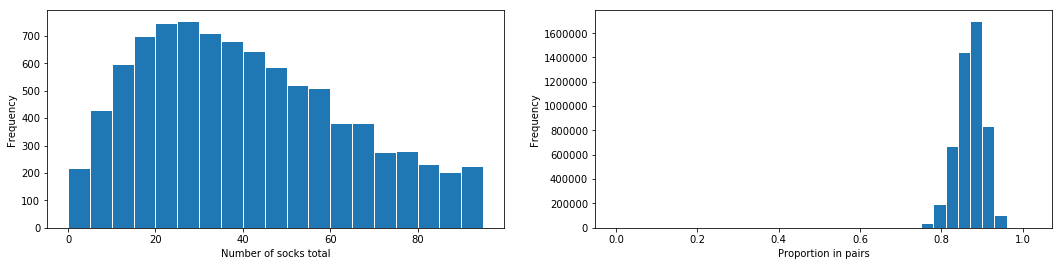

In [268]:
plt.subplots(1, 2, figsize=(18,4))


p_mu = dfSocks.mean()[0]
p_square = p_mu**2
p_std = dfSocks.std()[0]
p_len = -p_square / (p_mu - p_std**2)
p_prob = 1 - p_square / (p_len * p_std**2) 

plt.subplot(1,2,1)
x = stats.nbinom.rvs(n=p_len, p=p_prob, size=10000)
plt.hist(x, bins=list(range(0,100,5)), edgecolor = 'white')
plt.xlabel('Number of socks total')
plt.ylabel('Frequency')

#alpha / alpha + beta
p_alpha = 95
p_beta  = 5

plt.subplot(1,2,2)
x = stats.beta.rvs(a=prior_alpha, b=prior_beta, size=5000000)
plt.hist(x, bins=np.arange(0,1.03,.03), edgecolor = 'white')
plt.xlabel('Proportion in pairs')
plt.ylabel('Frequency')
plt.show()

Plot the same two-panel figure as in **3a**, but instead of the Karl Broman/blog post prior histograms, include with our CSCI 3202 data your revised prior distributions.

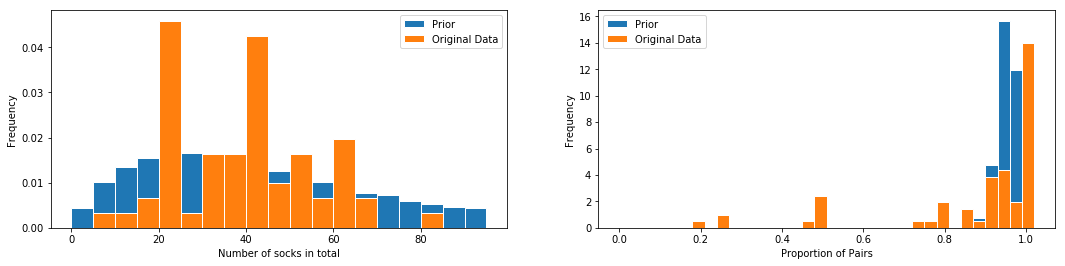

In [269]:
plt.subplots(1, 2, figsize=(18,4))
prior_mu = 48.144928
prior_sd = 34.192481
prior_size = -prior_mu**2 / (prior_mu - prior_sd**2)
prior_p = 1 - prior_mu**2 / (prior_size * prior_sd**2) #probability of a success in a given trial

plt.subplot(1,2,1)
x = stats.nbinom.rvs(n=prior_size, p=prior_p, size=100000)
plt.hist(x, bins=list(range(0,100,5)), edgecolor='white', label="Prior",stacked=True,normed = True)
plt.hist(dfSocks["n_socks"], bins=list(range(0,100,5)), edgecolor='white', label="Original Data",stacked=True,normed = True)
plt.xlabel('Number of socks in total')
plt.ylabel('Frequency')
plt.legend(loc="upper right")

#alpha / alpha + beta
prior_alpha = 95
prior_beta  = 5

plt.subplot(1,2,2)
x = stats.beta.rvs(a=prior_alpha, b=prior_beta, size=100000)
plt.hist(x, bins=np.arange(0,1.03,.03), edgecolor='white', label="Prior",stacked=True,normed = True)
plt.hist(dfSocks["prop_pairs"], bins=np.arange(0,1.03,.03), edgecolor='white', label="Original Data",stacked=True,normed = True)
plt.xlabel('Proportion of Pairs')
plt.ylabel('Frequency')
plt.legend(loc="upper left")
plt.show()


<br>

<a/ id='p3c'></a>

### (3c) Do your laundry!

**Now:** Suppose we draw 10 socks out of the laundry and there is one pair and 8 unique socks. Update your prior distributions based on these data.  Use the same **accept/reject likelihood function** form that we used in class. Use at least 10,000 iterations.

Provide a two-panel figure (two rows x one column):
1. Top panel is a histogram of samples from your prior distribution for `n_socks`
1. Bottom panel is a histogram of samples from the posterior distribution resulting from your accept/reject approximate Bayesian computation

Make sure the limits of your horizontal `n_socks`-axis are the same for both panels, to make for an easier comparison, and that all axes are labelled appropriately.

Note that the model `sock_model` from class is defined in the helper functions below.  It should not need modified, but if you want to modify it you can.

In [270]:
n_picked = 10     
n_iter = 10000  

results = []

for k in range(n_iter):
    n_socks = int(stats.nbinom.rvs(n=prior_size, p=prior_p, size=1))
    prop_pairs = float(stats.beta.rvs(a=prior_alpha, b=prior_beta, size=1))
    unique, pairs = sock_model(n_socks=n_socks, prop_pairs=prop_pairs, n_picked=n_picked)       
    results.append([unique, pairs, n_socks, prop_pairs])
    
df_socks_part_1 = pd.DataFrame(results, columns=['unique', 'pairs', 'n_socks', 'prop_pairs'])
df_socks_part_1.head()

,unique,pairs,n_socks,prop_pairs
0,6,2,32,0.969032
1,8,1,42,0.960052
2,8,1,40,0.962760
3,6,2,20,0.927358
4,10,0,36,0.947635


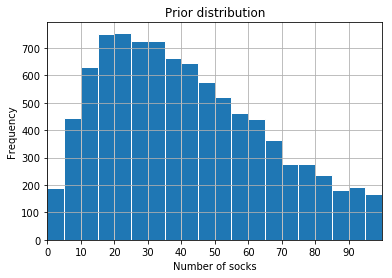

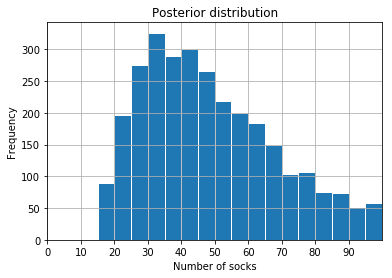

In [271]:
ax = df_socks_part_1["n_socks"].hist(bins=range(0,105,5), edgecolor="white")

plt.xlim([0, 100])
plt.xlabel('Number of socks')
plt.title('Prior distribution')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.show()

#8 socks, 1 pair
ax = df_socks_part_1.loc[(df_socks_part_1["unique"]==8) & (df_socks_part_1["pairs"]==1), "n_socks"].hist(
    bins=range(0,105,5), edgecolor="white")
plt.xlim([0, 100])
plt.xlabel('Number of socks')
plt.title('Posterior distribution')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.show()

Write a few sentences commenting on the effect of the Bayesian update of our prior distribution.  (A "Bayesian update" simply refers to the part where we calculate the likelihood function and use it to modify our prior distribution into our posterior distribution.)

We created a graph with a positive skew by tightening the bounds of our histogram. By narrowing the allowed parameters within our distributions, we are altering the frequency with which some sets of our socks appear.

As a result, we flattened the graph a little bit, making it less turbulent. (Standardizing the frequency of occurrence a little bit.)

<br>

<a/ id='p3d'></a>

### (3d) Do your laundry... again!

Now treat your resulting *posterior distributions* as the sample data from our class to develop ***updated prior distributions***.  The easiest way to do this is to assume the same functional form, but update the parameters of the distribution.

Clearly state what your updated prior distributions are and how you decided on these new distributions/parameters. Show any relevant calculations.

In [279]:
print("The new beta will be: ", 1-0.9534599274012043)

The new beta will be:  0.04654007259879567


In [274]:
df_number_of_socks = df_socks_part_1.loc[(df_socks_part_1["unique"]==8) & (df_socks_part_1["pairs"]==1), "n_socks"]
df_proportion_of_socks = df_socks_part_1.loc[(df_socks_part_1["unique"]==8) & (df_socks_part_1["pairs"]==1), "prop_pairs"]

posterior_median = df_number_of_socks.median()
posterior_sigma = df_number_of_socks.std()

posterior_size = -posterior_median**2 / (posterior_median - posterior_sigma**2)
posterior_probability = 1 - posterior_median**2 / (posterior_size * posterior_sigma**2)
posterior_alpha = 9534599274012043
posterior_beta =  465400725987957

print("Median of proportion of pairs: ", df_proportion_of_socks.median())

Median of proportion of pairs:  0.9534599274012043


Using some of our previous knowledge of probability and statistics, we will remember that the median is more useful in the analysis of data when our data sets are skewed. 

In this case, given that we have a positive skew in our graph, it would make sense to use our median, as our mean may be misrepresentative of the data set.

Likewise, we are going to increase the precision of our selection of alpha and beta, as we can get much, much closer to the whole value by using longer numbers in conjunction with our form: $\frac{\alpha}{\alpha + \beta}$

Suppose you do your laundry a second time, again with all of your socks in there at once.  This time, you pull 12 socks out of the laundry and get 3 pairs and 6 distinct socks.

**Now:** Based on our *updated* prior distributions, use the accept/reject likelihood function with these new data to update your priors a second time. Again, use at least 10,000 iterations.

In [275]:
n_picked = 12     
n_iter = 10000

results = []

for k in range(n_iter):
    n_socks = int(stats.nbinom.rvs(n=prior_size, p=prior_p, size=1))
    prop_pairs = float(stats.beta.rvs(a=prior_alpha, b=prior_beta, size=1))
    unique, pairs = sock_model(n_socks=n_socks, prop_pairs=prop_pairs, n_picked=n_picked)       
    results.append([unique, pairs, n_socks, prop_pairs])
    
df_socks_part_2 = pd.DataFrame(results, columns=['unique', 'pairs', 'n_socks', 'prop_pairs'])
df_socks_part_2.head()

,unique,pairs,n_socks,prop_pairs
0,10,1,42,0.961830
1,10,1,58,0.984009
2,10,1,46,0.956687
3,10,1,49,0.950395
4,8,2,20,0.912373


Provide a three-panel figure (three rows x one column):
1. First two panels are the same as in **3c**
1. Third (bottom) panel is the posterior distribution resulting from the second update

So the top panel is only the prior distribution (no data), the middle panel is a posterior updated once with data and the bottom panel is a posterior distribution updated with two sets of data.

Each update with data is called an **assimilation step** - we are assimilating laundry data.

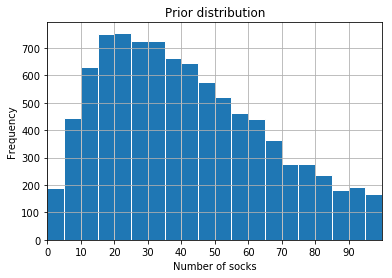

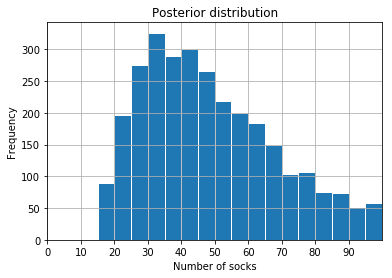

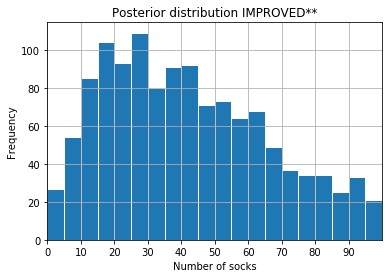

In [281]:
df_number_of_socks_2 = df_socks_part_2.loc[(df_socks_part_1["unique"]==6) & (df_socks_part_1["pairs"]==3), "n_socks"]
df_proportion_of_socks_2 = df_socks_part_2.loc[(df_socks_part_1["unique"]==6) & (df_socks_part_1["pairs"]==3), "prop_pairs"]

ax = df_socks_part_1["n_socks"].hist(bins=range(0,105,5), edgecolor="white")

plt.xlim([0, 100])
plt.xlabel('Number of socks')
plt.title('Prior distribution')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.show()

#8 socks, 1 pair
ax = df_socks_part_1.loc[(df_socks_part_1["unique"]==8) & (df_socks_part_1["pairs"]==1), "n_socks"].hist(
    bins=range(0,105,5), edgecolor="white")
plt.xlim([0, 100])
plt.xlabel('Number of socks')
plt.title('Posterior distribution')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.show()

ax = df_socks_part_1.loc[(df_socks_part_2["unique"]==6) & (df_socks_part_2["pairs"]==3), "n_socks"].hist(
    bins=range(0,105,5), edgecolor="white")
plt.xlim([0, 100])
plt.xlabel('Number of socks')
plt.title('Posterior distribution IMPROVED**')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.show()

<br>

<a/ id='p3e'></a>

### (3e) Some calculations

Calculate the 5-95% percentile (quantile) range for `n_socks` using each of: (1) the prior distribution, (2) the posterior distribution after one update, and (3) the posterior distribution after two updates.  These are called the 90% **credible intervals** in this Bayesian setting, in contrast to the frequentist confidence interval.

In [282]:
prior_quantile_lower = dfSocks["n_socks"].quantile(0.05)
prior_quantile_upper = dfSocks["n_socks"].quantile(0.95)
post_quantile_1_8_lower = df_socks_part_1.loc[(df_socks_part_1["unique"]==8) & (df_socks_part_1["pairs"]==1), "n_socks"].quantile(0.05)
post_quantile_1_8_upper = df_socks_part_1.loc[(df_socks_part_1["unique"]==8) & (df_socks_part_1["pairs"]==1), "n_socks"].quantile(0.95)
post_quantile_3_6_lower = df_socks_part_2.loc[(df_socks_part_2["unique"]==6) & (df_socks_part_2["pairs"]==3), "n_socks"].quantile(0.05)
post_quantile_3_6_upper = df_socks_part_2.loc[(df_socks_part_2["unique"]==6) & (df_socks_part_2["pairs"]==3), "n_socks"].quantile(0.95)

print("Prior Distribution of socks (5 - 95% percentile): [{}, {}]".format(prior_quantile_lower, prior_quantile_upper))
print("Posterior Distribution of Socks (1 pair, 8 Distinct: 5 - 95% percentile) [{}, {}]".format(post_quantile_1_8_lower, post_quantile_1_8_upper))
print("Posterior Distribution of Socks (3 pair, 6 Distinct: 5 - 95% percentile) [{}, {}]".format(post_quantile_3_6_lower, round(post_quantile_3_6_upper, 2)))

Prior Distribution of socks (5 - 95% percentile): [18.8, 100.0]
Posterior Distribution of Socks (1 pair, 8 Distinct: 5 - 95% percentile) [22.0, 110.0]
Posterior Distribution of Socks (3 pair, 6 Distinct: 5 - 95% percentile) [16.0, 60.05]


Write a few sentences commenting on similarities/differences between your original prior distribution (for the class data set), and the two updated posterior distributions, as well as the differences in the estimated credible intervals. Explain why the distributions/credible intervals are changing as they are, as more data are assimilated.

The general level of certainty has been raised, at the cost of a wider band of data, as can be seen with the first Posterior Distribution. If you note, however, that there is a massive increase in certainty (with a much, much smaller width) in the second assimilation step, you will see that our adjustments are reducing overall uncertainty within our data set. 

By focusing in on the Median, we can attempt to normalize the data as much as is  feasible, assuming that our data is at least a little irregular.

The quartiles will continue to have tighter and  tighter bounds as we normalize around the other stats. If we adjusted the values around the mean (as well as the median), I would suspect at least a marginal increase in accuracy across the board. Likewise, we could incorporate in the standard deviation for this distribution to get an even more precise posterior distribution.

On top of all of *that*, we could take more trials. At the time of writing, I believe we took 10,000 trials, but to improve our certainty we could increase this to 1,000,000 or more. (I won't do that for our computers' sake. Likewise, Python flips out if we do more than 10,000 trials. At least, on my machine.)

<br>

**Concluding note:** This only is technically accurate estimation if we assume that all of your socks are in the laundry at the same time. Or if we revise our prior distributions to estimate the number of socks we have in the laundry in any given load. But that's way harder to pin down.

**Also:** Yes, I did wait to post this until after the Quizlet closed so I could include as much sock data as possible.

<br><br><br>

<a id='helpers'></a>

---

[Back to top](#top)

## Some things that might be useful

Easiest way to start:  Click this cell, go to "Cell" in the toolbar above, and click "Run All Below"

In [2]:
import pandas as pd
import numpy as np
import copy as cp
import itertools
from scipy import stats
from math import floor
import matplotlib.pyplot as plt
from time import time

## Definitely useful

In [3]:
def slr(alpha, Teq, temperature):
    '''sea-level emulator of Rahmstorf 2007 (DOI: 10.1126/science.1135456)
    Takes global mean temperature as forcing, and parameters:
    alpha = temperature sensitivity of sea level rise, and
    Teq   = equilibrium temperature,
    and calculates a rise/fall in sea levels, based on whether the temperature
    is warmer/cooler than the equilibrium temperature Teq.
    Here, we are only worrying about alpha (for now!)'''

    n_time = len(temperature)
    deltat = 1
    sealevel = [0]*n_time
    sealevel[0] = -134
    for t in range(n_time-1):
        sealevel[t+1] = sealevel[t] + deltat*alpha*(temperature[t]-Teq)

    return sealevel


def sock_model(n_socks, prop_pairs, n_picked):
    
    n_pairs = int( floor(n_socks/2) * prop_pairs)
    n_odd = n_socks - 2*n_pairs

    # label all our socks
    socks = []
    for i in range(n_pairs):
        socks = socks + [i]*2
    for j in range(n_pairs, n_pairs+n_odd):
        socks = socks + [j]

    if len(socks)>0:
        # pick our socks out of the dryer
        picked_socks = list(np.random.choice(socks, size=min(n_picked, n_socks), replace=False))
        sock_counts = [picked_socks.count(k) for k in range(max(socks)+1)]

        # how many were singleton socks?
        unique = sock_counts.count(1)

        # how many were in pairs?
        pairs = sock_counts.count(2)
        
    else:
        unique = 0
        pairs = 0
    
    return unique, pairs


[Back to top](#top)